# Time Evolving Block Decimation (TEBD)

In this notebook, we will implement the Time-Evolving Block Decimation (TEBD) algorithm seen in the course. TEBD is a relatively simple yet powerful algorithm for computing quantum dynamics with MPS. We will use the transverse field Ising model as an example.

## Table of Contents

1. Transverse Field Ising Model
2. Implementing TEBD Step by Step
3. Creating the Gates
4. Preparing the Initial State
5. Measuring Observables
6. Putting it all together
7. Exercises

## 1. Transverse Field Ising Model

The Hamiltonian for the transverse field Ising model is given by:

$$
H_{\text{TFI}} = -J \sum_{i=0}^{N-2} \sigma_i^z \sigma_{i+1}^z - h \sum_{i=0}^{N-1} \sigma_i^x
$$


where:
- $J$ is the interaction strength,
- $h$ is the transverse magnetic field,
- $\sigma_i^z$ and $\sigma_i^x$ are the Pauli matrices acting on the $i$-th site.

The TEBD algorithm allows us to simulate the time evolution of the some initial state $|\psi\rangle$ under this Hamiltonian.

Let's define variables for the Pauli operators and the coefficients $J$ and $h$:

In [561]:
import numpy as np

# TFI parameters:
J = 1.0
h = 1.0
N = 10

# Define the Pauli spin operators and identity operator
i = np.array([[1, 0], [0, 1]])
sx = np.array([[0, 1], [1, 0]])
sy = np.array([[0, -1j], [1j, 0]])
sz = np.array([[1, 0], [0, -1]])


## 2. Implementing TEBD Step by Step

### a) Local update
First, we will focus on the local update wherein one 2-body gate is applyed to the MPS. 

The local update consists of 4 steps set out in the course slides (1. Contract, 2. SVD + truncate, 3. Insert identity, 4. Contract). After the local update is complete **2 gamma tensors and 1 lambda matrix** will have been updated.

![](../img/local_update.png)

The function below performs the first step of contracting the sites and 2-qubit gate:

In [562]:
def contract_sites_and_gate(
    lambda_left: np.ndarray, 
    gamma_left: np.ndarray, 
    lambda_centre: np.ndarray, 
    gamma_right: np.ndarray, 
    lambda_right: np.ndarray,
    gate: np.ndarray,
) -> np.ndarray:
    """
    Contract the two-body gate with the mps site tensors.

    Args:
        lambda_left: The lambda matrix to the left of the left gamma tensor
        gamma_left: The left gamma tensor
        lambda_centre: The lambda matrix in between the two gamma tensors
        gamma_right: The right gamma tensor
        lambda_right: The lambda matrix to the right of the right gamma tensor
        gate: The 2-body gate

    Returns:
        Theta, an order-4 tensor resulting from the contraction.
    """
    theta = np.einsum('ab,bgc,cd,dhe,ef,ghij->aijf',
        np.diagflat(lambda_left), 
        gamma_left, 
        np.diagflat(lambda_centre), 
        gamma_right, 
        np.diagflat(lambda_right), 
        gate
    )
    return theta

**Note: Since the lambda matrices are diagonal, they can be stored as a 1-dimension array containing the diagonal elements only.**

Next, we carry out step 2: splitting the resulting tensor with an SVD and truncation. For simplicity we will specify the maximum number of singlar values to retain after the SVD - this will determine the maximum value for the bond dimension of the MPS. We could have instead specified the truncation error.

Any very small singular values (<10^-14) we remove, otherwise they will cause problems when we need to compute $\lambda^{-1}$.

In [563]:
from typing import Tuple

def perform_svd_and_truncate(
    theta: np.ndarray,
    max_bond_dimension: int,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Splits the theta tensor via an SVD and performs a truncation.
    
    Args:
        theta: The order-4 tensor
        max_bond_dimension: The maximum number of singlar values to keep after the truncation, 
            this will determine the maximum value for the bond dimension of the MPS

    Returns:
        The order-3 tensor U, the updated lambda_centre matrix, the order-3 tensor Vdagger
    """
    D1, d1, d2, D2 = theta.shape
    U, s, Vt = np.linalg.svd(np.reshape(theta, [D1*d1, d2*D2]))
    
    # Choose the number of singular values to keep: 
    # We keep at most max_bond_dimension singular values and truncate singular values smaller than 10**-14
    
    # If we don't remove small singular values here we'll have 
    # problems when we come to inverting the lambda matrix
    r = min(max_bond_dimension, np.count_nonzero(s >= 10**-14))
    
    U = np.reshape(U[:,:r], [D1, d1, r])
    Vt = np.reshape(Vt[:r, :], [r, d2, D2])
    return U, s[:r], Vt

Then, we perform steps 3 and 4.

In [564]:
def insert_identity_and_contract(
    lambda_left: np.ndarray,
    U: np.ndarray,
    lambda_centre_updated: np.ndarray,
    Vdagger: np.ndarray,
    lambda_right: np.array,
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Contracts the inverted left and right lambda matrices with U and Vdagger to obtain the updated gamma tensors.

    Args:
        lambda_left: The lambda matrix to the left of the left gamma tensor
        U: The U tensor returned by `perform_svd_and_truncate`
        lambda_centre_updated: The updated lambda_centre matrix returned by `perform_svd_and_truncate`
        Vdagger: The Vdagger tensor returned by `perform_svd_and_truncate`
        lambda_right: The lambda matrix to the right of the right gamma tensor

    Returns:
        The updated gamma_left tensor, the updated gamma_right_tensor
    """
    lambda_right_inverted = np.linalg.inv(np.diagflat(lambda_right))
    lambda_left_inverted = np.linalg.inv(np.diagflat(lambda_left))
    gamma_left_updated = np.einsum('ab,bcd->acd', lambda_left_inverted, U)
    gamma_right_updated = np.einsum('abc,cd->abd', Vdagger, lambda_right_inverted)
    return gamma_left_updated, lambda_centre_updated, gamma_right_updated

Finally, let's combine all those steps into a function for the full local update.

In [565]:
def local_update(
    lambda_left: np.ndarray, 
    gamma_left: np.ndarray, 
    lambda_centre: np.ndarray, 
    gamma_right: np.ndarray, 
    lambda_right: np.ndarray,
    gate: np.ndarray,
    max_bond_dimension: int
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Performs the full local update.

    Args:
        lambda_left: The lambda matrix to the left of the left gamma tensor
        gamma_left: The left gamma tensor
        lambda_centre: The lambda matrix in between the two gamma tensors
        gamma_right: The right gamma tensor
        lambda_right: The lambda matrix to the right of the right gamma tensor
        gate: The 2-body gate
        max_bond_dimension: The maximum bond dimension of the MPS

    Returns:
        The updated gamma_left tensor, the updated lambda_centre matrix, the updated gamma_right tensor
    """
    theta = contract_sites_and_gate(lambda_left, gamma_left, lambda_centre, gamma_right, lambda_right, gate)
    UsVt = perform_svd_and_truncate(theta, max_bond_dimension)
    gamma_left_updated, lambda_centre_updated, gamma_right_updated = insert_identity_and_contract(lambda_left, *UsVt, lambda_right)
    return gamma_left_updated, lambda_centre_updated, gamma_right_updated
    

### b) Global update

![](../img/global_updates.png)

Now that we have a single local update we want to apply this function for every 2-qubit gate. We will write a function that applies the local update for all odd gates (gates whose left leg acts on a site whose index is odd), followed by all even gates (gates whose left leg acts on a site whose index is even). After one call to this function the MPS will have evolved by one time step dt.

The function will apply all odd/even gates in series (one after the other). However note that each odd/even gate can be applied independently of all other odd/even gates, meaning that they could be applied in **parallel**.

In [566]:
def global_update(
    lambdas: list,
    gammas: list,
    odd_gates: list,
    even_gates: list,
    max_bond_dimension: int,
) -> Tuple[list, list]:
    """
    Perform the global update applying all gates (odd and even) once.

    Args:
        lambdas: A list of length N+1 containing the lambda matrices of the MPS
        gammas: A list of length N containing the gamma tensors of the MPS
        odd_gates: A list containing the odd gates
        even_gates: A list containing the even gates
        max_bond_dimension: The maximum bond dimension of the MPS

    Returns:
        The list of updated lambdas, the list of updated gammas
    """
    nsites = len(gammas)
    for gate, site in zip(odd_gates, range(1, nsites, 2)):
        gammas[site], lambdas[site+1], gammas[site+1] = local_update(
            lambdas[site], 
            gammas[site], 
            lambdas[site+1], 
            gammas[site+1], 
            lambdas[site+2],
            gate,
            max_bond_dimension,
        )
    for gate, site in zip(even_gates, range(0, nsites, 2)):
        gammas[site], lambdas[site+1], gammas[site+1] = local_update(
            lambdas[site], 
            gammas[site], 
            lambdas[site+1], 
            gammas[site+1], 
            lambdas[site+2],
            gate,
            max_bond_dimension,
        )
    return lambdas, gammas

## 3. Creating the Gates

Now that we have the global update function we need to construct the gates for our Hamiltonian. 

The Hamiltonain $H_{\text{TFI}}$ can be written as a sum of local 2-qubit terms:

$
H_{\text{TFI}} = \sum_{i}H_{i,i+1},
$

where

$H_{i,i+1} = -J\sigma^{z}_{i}\otimes\sigma^{z}_{i+1} - \frac{h}{2}(\sigma^{x}_{i}\otimes I + I\otimes\sigma_{i+1}^{x})$, for $i\in(0, N-2)$, 

$H_{0, 1} = -J\sigma^{z}_{0}\otimes\sigma^{z}_{1} - \frac{h}{2}( 2\sigma^{x}_{0}\otimes I + I\otimes\sigma_{1}^{x})$,

$H_{N-2, N-1} = -J\sigma^{z}_{N-2}\otimes\sigma^{z}_{N-1} - \frac{h}{2}( \sigma^{x}_{N-2}\otimes I + 2I\otimes\sigma_{N-1}^{x})$.

Note how the 1-qubit operator is split between neighbouring 2-qubit gates. We need to include a factor of 1/2 to avoid counting them twice expect on the first and last sites which are covered by just one 2-qubit gate.

The local two-body gates we need to apply are then given by $\exp{(-i\delta t H_{i,i+1})}$.

First let's define the local operators appearing in $H_{\text{TFI}}$:

In [567]:
# Sz x Sz
szz = np.kron(sz, sz)
# I x Sx
isx = np.kron(i, sx)
# Sx x I
sxi = np.kron(sx, i)

Now we can contruct the gates $\exp{(-i\delta t H_{i,i+1})}$ for $i\in[0,N-2]$:

In [568]:
import scipy as sp

# Define Trotter delta 
delta_t = 0.1

h_local_bulk = -J * szz - (h / 2) * (sxi + isx)
h_local_first = -J * szz - (h / 2) * (2 * sxi + isx)
h_local_last = -J * szz - (h / 2) * (sxi + 2 * isx)

# Note: we need the exponential of an *operator* here, hence we must use scipy.linalg.expm 
# and not numpy.exp, numpy.exp computes the element-wise exponential
gate2_bulk = np.reshape(sp.linalg.expm(-1j * delta_t * h_local_bulk), [2, 2, 2, 2])
gate2_first = np.reshape(sp.linalg.expm(-1j * delta_t * h_local_first), [2, 2, 2, 2])
gate2_last = np.reshape(sp.linalg.expm(-1j * delta_t * h_local_last), [2, 2, 2, 2])

We will create two lists of gates, one for the odd gates and one for the even gates.

In [569]:
even_gates = [gate2_first if i==0 else (gate2_last if i==N-2 else gate2_bulk) for i in range(0, N-1, 2)]
odd_gates = [gate2_first if i==0 else (gate2_last if i==N-2 else gate2_bulk) for i in range(1, N-1, 2)]

## 4. Preparing the Initial State

Finally, we need to create our initial wave-function $|\psi(0)\rangle$. The initial wave-function needs to be given in the canonical gauge. For this we will slightly modify the `product_state_mps` function seen in the course:

In [570]:
from itertools import repeat
def product_state_mps(state: list) -> Tuple[list, list]:
    """
    Generate an MPS in the canonical gauge representing a product state

    Args:
        state: A list of state vectors

    Returns:
        A list of length N+1 containing the lambdas, A list of length N containing the gammas
    """
    N = len(state)
    lambdas = list(repeat(np.array([1]), N+1)) # lambdas are stored as 1-d arrays
    gammas = [np.array(s).reshape(1, len(s), 1) for s in state]
    return lambdas, gammas

We will use the initial state $|\psi(0)\rangle = |0000000000\rangle$.

In [571]:
initial_state = [[1, 0]] * N
psi = product_state_mps(initial_state)

## 5. Measuring Observables

We saw previously how to measure observables on MPS, however now that we are working in the canonical gauge we will need to slightly modify our function.

In [572]:
def measure_one_site_operator(lambdas: list, gammas: list, op: np.ndarray, site_index: int):
    """
    Compute expectation of single-site operator

    Args:
        lambdas: A list of length N+1 containing the lambdas of the mps
        gammas: A list of length N containing the gammas of the mps
        op: The operator to measure
        site_index: The site on which to measure the operator
    
    Returns:
        The expectation value
    """
    return float(np.real(
        np.einsum('abc,ad,eb,cf,def',
                gammas[site_index],
                np.diagflat(lambdas[site_index]**2),
                op,
                np.diagflat(lambdas[site_index+1]**2),
                np.conj(gammas[site_index]), # Don't forget to perform the complex conjugate to form the bra
                )
    ))

## 6. Putting it all together

Now, using everything we have developed we can evolve our product state under the TFI Hamiltonian and measure an observable between each time step.

In [573]:
num_steps = 100
max_bond_dimension = 5

exp_sz = []
for step in range(num_steps):
    exp_sz.append(measure_one_site_operator(*psi, sz, 0))
    psi = global_update(*psi, odd_gates, even_gates, max_bond_dimension)


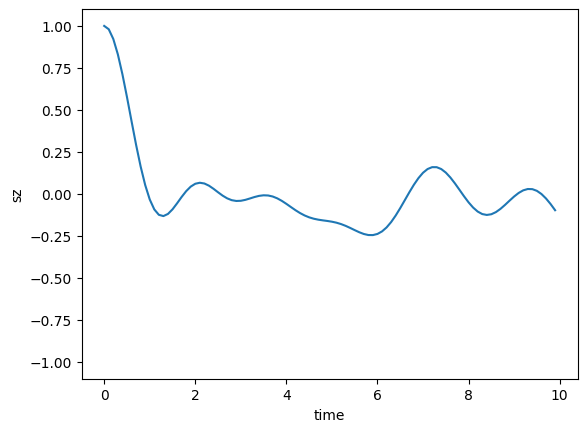

In [574]:
import matplotlib.pyplot as plt
plt.xlabel("time")
plt.ylabel("sz")
plt.ylim([-1.1, 1.1])
plt.plot([i*delta_t for i in range(num_steps)], exp_sz)

## 7. Exercices

1. Visualize the time evolution of $\langle\psi(t)|\sigma_{z}|\psi(t)\rangle$ and $\langle\psi(t)|\sigma_{x}|\psi(t)\rangle$ on all qubits.
2. Experiment with changing $J$ and $h$.
3. Experiment with different initial states.
4. Plot the entropy of entanglement at the middle of the chain as a function of time.